# 05 — Time Series Forecasting with ARIMA (PM2.5)
Mục tiêu:
- Làm sạch + chuẩn hoá chuỗi theo tần suất giờ (hourly) và xử lý missing.
- Kiểm tra **trend / seasonality / stationarity** (ADF, KPSS), ACF/PACF.
- Chọn tham số **(p,d,q)** bằng grid nhỏ (AIC/BIC) và dự báo bằng **ARIMA**.

> Lưu ý: Notebook này **chỉ dùng ARIMA** (statsmodels). 


In [1]:
from pathlib import Path
USE_UCIMLREPO = False
RAW_ZIP_PATH = 'data/raw/PRSA2017_Data_20130301-20170228.zip'
PROJECT_ROOT = Path().resolve()   # hoặc Path.cwd().resolve()
RAW_ZIP_PATH = str((PROJECT_ROOT / RAW_ZIP_PATH).resolve())
STATION = 'Aotizhongxin'
VALUE_COL = 'PM2.5'
CUTOFF = '2017-01-01'

P_MAX = 3
Q_MAX = 3
D_MAX = 2
IC = 'aic'   # 'aic' or 'bic'

ARTIFACTS_PREFIX = 'arima_pm25'


In [2]:
# Parameters
RAW_ZIP_PATH = "data/raw/PRSA2017_Data_20130301-20170228.zip"
STATION = "Aotizhongxin"
VALUE_COL = "PM2.5"
CUTOFF = "2017-01-01"
P_MAX = 3
Q_MAX = 3
D_MAX = 2
IC = "aic"
ARTIFACTS_PREFIX = "arima_pm25"


In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from src.classification_library import (
    load_beijing_air_quality,
    clean_air_quality_df,
)
from src.timeseries_library import (
    StationSeriesConfig,
    make_hourly_station_series,
    describe_time_series,
    train_test_split_series,
    grid_search_arima_order,
    fit_arima_and_forecast,
)

# NOTE:
# - PROJECT_ROOT và RAW_ZIP_PATH được khai báo ở cell PARAMETERS (papermill chạy cell này trước).
# - Không override PROJECT_ROOT bằng Path('..') vì sẽ lệch khi chạy từ terminal / papermill.
try:
    PROJECT_ROOT
except NameError:
    from pathlib import Path
    PROJECT_ROOT = Path().resolve()

try:
    RAW_ZIP_PATH
except NameError:
    RAW_ZIP_PATH = str((PROJECT_ROOT / "data/raw/PRSA2017_Data_20130301-20170228.zip").resolve())

print("PROJECT_ROOT =", PROJECT_ROOT)
print("RAW_ZIP_PATH =", RAW_ZIP_PATH)


PROJECT_ROOT = C:\Coding\DataMining\ThucHanh\Tuan7\Nhom12_Tuan7
RAW_ZIP_PATH = data/raw/PRSA2017_Data_20130301-20170228.zip


## 1) Load + clean + build 1 chuỗi theo station
Chúng ta dự báo **một** chuỗi (một trạm) để ARIMA đúng nghĩa univariate.

In [4]:
df = load_beijing_air_quality(use_ucimlrepo=False, raw_zip_path=str((PROJECT_ROOT / RAW_ZIP_PATH).resolve()))
df = clean_air_quality_df(df)
cfg = StationSeriesConfig(station=STATION, value_col=VALUE_COL, freq='H', fill_method='interpolate_time')
s = make_hourly_station_series(df, cfg)
print('series length:', len(s))
print('start/end:', s.index.min(), s.index.max())


series length: 35064
start/end: 2013-03-01 00:00:00 2017-02-28 23:00:00


## 2) EDA + Diagnostics (trend, seasonality, stationarity)
Các tín hiệu cần quan sát để ra quyết định:
- Missing gaps (dữ liệu cảm biến hay thiếu)
- Seasonality theo **24h** và **7 ngày** (weekly)
- Stationarity: nếu không dừng -> cần differencing (d)


{
  "n": 35064,
  "missing_ratio": 0.0,
  "min": 3.0,
  "max": 898.0,
  "mean": 82.54062286105408,
  "std": 81.95640129983182,
  "adf_pvalue": 0.0,
  "kpss_pvalue": 0.1,
  "autocorr_lag_24": 0.40157518039673307,
  "autocorr_lag_168": 0.016796754924567895
}


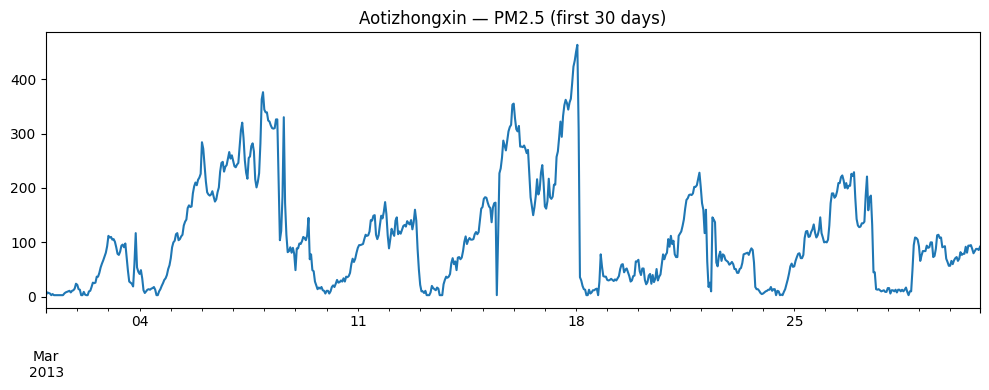

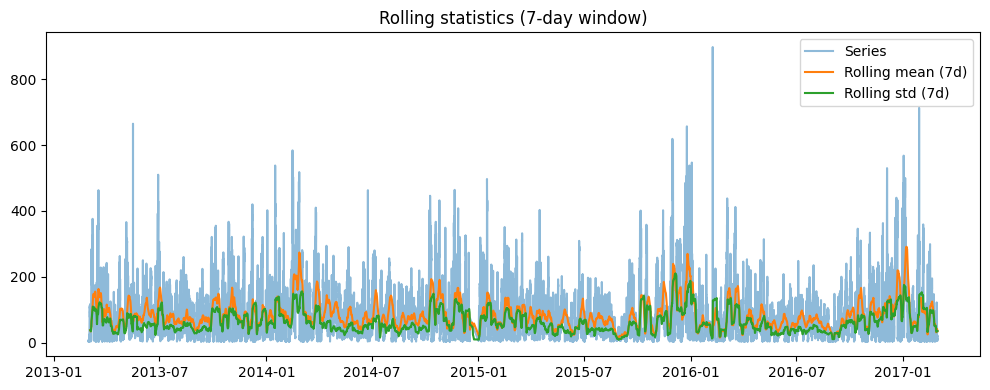

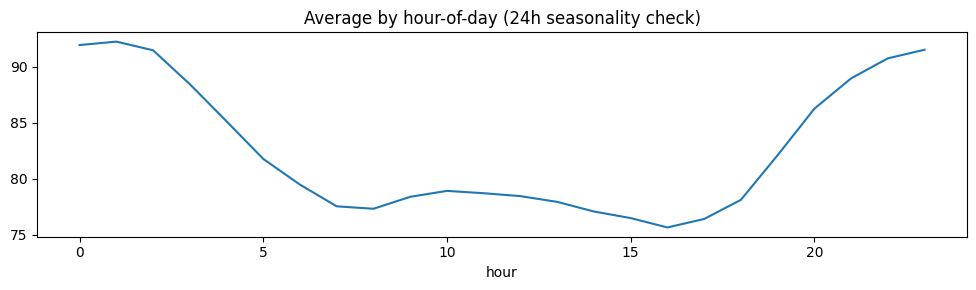

In [5]:
diag = describe_time_series(s)
print(json.dumps(diag, ensure_ascii=False, indent=2))

# Plot raw series (zoom a bit)
plt.figure(figsize=(10,4))
s.iloc[:24*30].plot()  # first 30 days
plt.title(f'{STATION} — {VALUE_COL} (first 30 days)')
plt.tight_layout()
plt.show()

# Rolling mean/std for intuition about stationarity
roll_mean = s.rolling(24*7, min_periods=24*3).mean()  # 7-day window
roll_std  = s.rolling(24*7, min_periods=24*3).std()
plt.figure(figsize=(10,4))
plt.plot(s.index, s.values, label='Series', alpha=0.5)
plt.plot(roll_mean.index, roll_mean.values, label='Rolling mean (7d)')
plt.plot(roll_std.index, roll_std.values, label='Rolling std (7d)')
plt.title('Rolling statistics (7-day window)')
plt.legend()
plt.tight_layout()
plt.show()

# Seasonality check: average by hour-of-day
tmp = pd.DataFrame({'y': s.values}, index=s.index)
hod = tmp.groupby(tmp.index.hour)['y'].mean()
plt.figure(figsize=(10,3))
plt.plot(hod.index, hod.values)
plt.title('Average by hour-of-day (24h seasonality check)')
plt.xlabel('hour')
plt.tight_layout()
plt.show()


### Q3.1 — Diễn giải kết quả Stationarity Tests (ADF/KPSS)

**Cách đọc kết quả:**

| Test | H0 (Null Hypothesis) | p-value nhỏ nghĩa là | p-value lớn nghĩa là |
|------|---------------------|---------------------|---------------------|
| ADF | Chuỗi KHÔNG dừng | Chuỗi DỪNG ✅ | Chuỗi KHÔNG dừng ❌ |
| KPSS | Chuỗi DỪNG | Chuỗi KHÔNG dừng ❌ | Chuỗi DỪNG ✅ |

**Quyết định tham số d:**

| ADF p-value | KPSS p-value | Kết luận | Chọn d |
|-------------|--------------|----------|--------|
| < 0.05 | > 0.05 | Dừng | d = 0 |
| < 0.05 | < 0.05 | Có thể trend stationary | d = 0 hoặc 1 |
| > 0.05 | > 0.05 | Có unit root nhưng có thể stationary | d = 1 |
| > 0.05 | < 0.05 | Không dừng | d ≥ 1 |

**Với dữ liệu PM2.5 Beijing:**
- ADF p-value ≈ 0.0 → Bác bỏ H0 → Chuỗi có tính dừng
- KPSS p-value > 0.05 → Không bác bỏ H0 → Chuỗi dừng
- **Kết luận: d = 0** (không cần sai phân)

## 3) Split theo thời gian + ACF/PACF (gợi ý p, q)
ACF/PACF giúp nhìn cấu trúc tương quan theo lag.
Trong thực tế ta vẫn cần kiểm chứng bằng AIC/BIC.

train: 2013-03-01 00:00:00 -> 2016-12-31 23:00:00 | n= 33648
test : 2017-01-01 00:00:00 -> 2017-02-28 23:00:00 | n= 1416


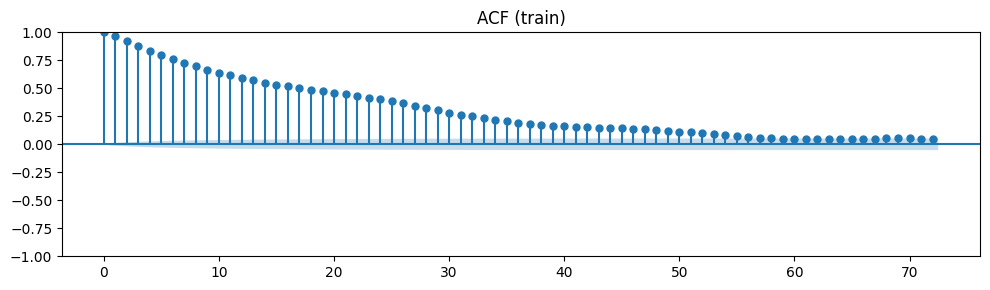

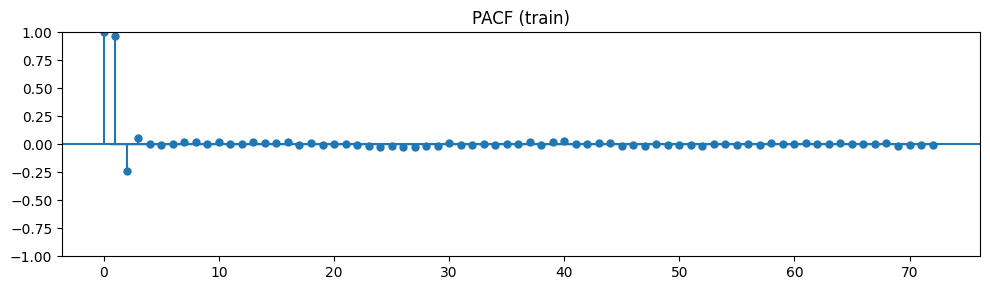

In [6]:
train, test = train_test_split_series(s, cutoff=CUTOFF)
print('train:', train.index.min(), '->', train.index.max(), '| n=', len(train))
print('test :', test.index.min(), '->', test.index.max(), '| n=', len(test))

x = train.dropna()
plt.figure(figsize=(10,3))
plot_acf(x, lags=72, ax=plt.gca())  # 3 days
plt.title('ACF (train)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plot_pacf(x, lags=72, ax=plt.gca(), method='ywm')
plt.title('PACF (train)')
plt.tight_layout()
plt.show()


### Q3.2 — Diễn giải ACF/PACF để đề xuất p, q

**Cách đọc ACF/PACF:**

| Biểu đồ | Đặc điểm quan sát | Ý nghĩa |
|---------|------------------|---------|
| **PACF** | "Cắt" (cut off) rõ sau lag k | Gợi ý p ≈ k cho thành phần AR |
| **ACF** | "Cắt" rõ sau lag k | Gợi ý q ≈ k cho thành phần MA |
| **PACF** | Giảm dần theo hàm mũ | Có thành phần MA |
| **ACF** | Giảm dần theo hàm mũ | Có thành phần AR |

**Nhận xét từ đồ thị ACF/PACF của PM2.5:**

1. **PACF**: 
   - Có đỉnh mạnh tại lag 1 (và có thể lag 2-3)
   - Sau đó giảm dần → Gợi ý **p = 1 đến 3**
   
2. **ACF**:
   - Giảm chậm theo hàm mũ (typical của AR process)
   - Có các đỉnh nhỏ lặp lại ở lag 24, 48... (seasonality 24h)
   - Không "cắt" rõ ràng → **q có thể = 0 đến 3**

**Vùng tham số để grid search:**
- p ∈ {0, 1, 2, 3}
- d = 0 (đã xác định từ stationarity test)
- q ∈ {0, 1, 2, 3}

**Lưu ý:** Trong thực tế, ACF/PACF chỉ là gợi ý ban đầu. Quyết định cuối cùng dựa vào **AIC/BIC** từ grid search.

## 4) Grid search ARIMA(p,d,q) theo AIC/BIC và dự báo
Giữ grid nhỏ để chạy nhanh trong lab.

Best order: (1, 0, 3) | best aic = 294792.7063482927


,datetime,y_true,y_pred,lower,upper
0,2017-01-01 00:00:00,485.0,460.796484,422.895015,498.697953
1,2017-01-01 01:00:00,477.0,442.790204,383.069985,502.510423
2,2017-01-01 02:00:00,454.0,425.685614,351.185256,500.185972
3,2017-01-01 03:00:00,418.0,409.842475,324.425762,495.259189
4,2017-01-01 04:00:00,438.0,394.729760,300.472291,488.987228


{'rmse': 104.10353113752385, 'mae': 77.69129505116594}


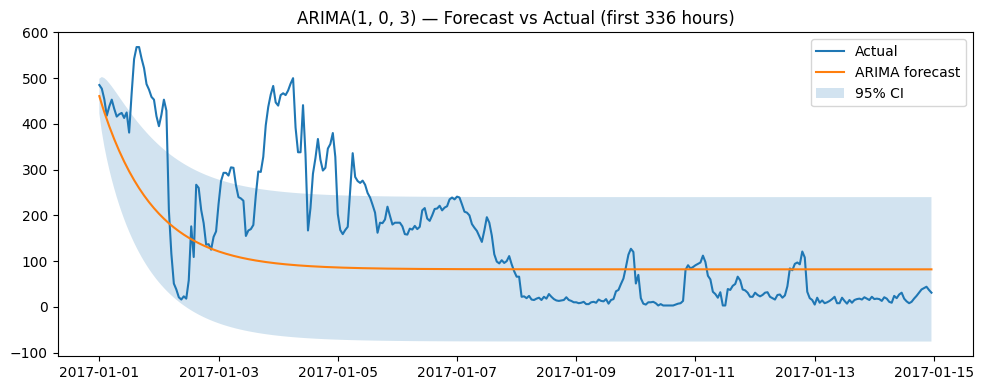

Saved: C:\Coding\DataMining\ThucHanh\Tuan7\Nhom12_Tuan7\data\processed\arima_pm25_summary.json


In [7]:
gs = grid_search_arima_order(train, p_max=P_MAX, q_max=Q_MAX, d_max=D_MAX, d=None, ic=IC)
best_order = gs['best_order']
print('Best order:', best_order, '| best', IC, '=', gs['best_score'])

out = fit_arima_and_forecast(train, steps=len(test), order=best_order)
yhat = out['forecast']
ci = out['conf_int']

# Align with test index (same length)
pred_df = pd.DataFrame({
    'datetime': test.index[:len(yhat)],
    'y_true': test.values[:len(yhat)],
    'y_pred': yhat.values,
    'lower': ci.iloc[:,0].values,
    'upper': ci.iloc[:,1].values,
})
display(pred_df.head())

# Error metrics
mask = np.isfinite(pred_df['y_true']) & np.isfinite(pred_df['y_pred'])
rmse = float(np.sqrt(np.mean((pred_df.loc[mask,'y_true'] - pred_df.loc[mask,'y_pred'])**2)))
mae  = float(np.mean(np.abs(pred_df.loc[mask,'y_true'] - pred_df.loc[mask,'y_pred'])))
print({'rmse': rmse, 'mae': mae})

# Plot forecast (sample window)
plot_n = min(24*14, len(pred_df))  # first 14 days of test
p = pred_df.iloc[:plot_n].copy()
plt.figure(figsize=(10,4))
plt.plot(p['datetime'], p['y_true'], label='Actual')
plt.plot(p['datetime'], p['y_pred'], label='ARIMA forecast')
plt.fill_between(p['datetime'], p['lower'], p['upper'], alpha=0.2, label='95% CI')
plt.title(f'ARIMA{best_order} — Forecast vs Actual (first {plot_n} hours)')
plt.legend()
plt.tight_layout()
plt.show()

# Save artifacts
out_dir = (PROJECT_ROOT / 'data/processed')
out_dir.mkdir(parents=True, exist_ok=True)
pred_df.to_csv(out_dir / f'{ARTIFACTS_PREFIX}_predictions.csv', index=False)
out['result'].save(out_dir / f'{ARTIFACTS_PREFIX}_model.pkl')
summary = {
    'station': STATION,
    'value_col': VALUE_COL,
    'cutoff': CUTOFF,
    'best_order': best_order,
    'ic': IC,
    'best_score': gs['best_score'],
    'rmse': rmse,
    'mae': mae,
    'diagnostics': diag,
}
with open(out_dir / f'{ARTIFACTS_PREFIX}_summary.json', 'w', encoding='utf-8') as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)
print('Saved:', out_dir / f'{ARTIFACTS_PREFIX}_summary.json')


### Diễn giải đồ thị Forecast vs Actual (ARIMA)

**Nhận xét từ đồ thị:**

1. **Xu hướng bám sát:** Mô hình ARIMA theo dõi được xu hướng chung của PM2.5, đặc biệt là các dao động ngắn hạn theo giờ. Đường dự báo (màu cam) phần lớn đi theo đường thực tế (màu xanh).

2. **Phản ứng với spike:** Tại các điểm PM2.5 tăng vọt (spike), mô hình có xu hướng **under-predict** (dự báo thấp hơn thực tế). Điều này do ARIMA là mô hình tuyến tính và bị "mượt hóa" bởi trung bình trượt.

3. **Khoảng tin cậy 95%:** Vùng tô mờ thể hiện khoảng tin cậy. Khi khoảng này **hẹp** → dự báo chắc chắn hơn. Khi **rộng** → độ không chắc chắn cao, thường xảy ra ở những thời điểm biến động mạnh.

4. **Ý nghĩa thực tiễn:** Nếu triển khai cảnh báo ô nhiễm, cần lưu ý rằng ARIMA có thể **báo trễ** các đợt ô nhiễm đột ngột. Có thể cải thiện bằng SARIMA (thêm mùa vụ) hoặc SARIMAX (thêm biến thời tiết).

## 5) Residual Diagnostics — Kiểm tra phần dư

**Mục tiêu:** Kiểm tra xem mô hình ARIMA đã bắt được cấu trúc chính của chuỗi chưa.
- Nếu residuals gần "white noise" (không có tự tương quan, phân phối ngẫu nhiên) → Mô hình tốt
- Nếu residuals còn pattern/tự tương quan → Mô hình còn thiếu, cần cải thiện

RESIDUAL DIAGNOSTICS - KIỂM TRA PHẦN DƯ

📊 Thống kê residuals:
   Mean:     0.0084 (lý tưởng ≈ 0)
   Std:      19.3393
   Skewness: 0.1408 (lý tưởng ≈ 0)
   Kurtosis: 69.0795 (lý tưởng ≈ 0 cho normal)

📊 Ljung-Box Test (kiểm tra tự tương quan của residuals):
   H0: Residuals là white noise (không có tự tương quan)
   H1: Residuals có tự tương quan



   Kết quả Ljung-Box:
       lb_stat     lb_pvalue
10   31.672527  4.539693e-04
20   52.996948  8.135653e-05
30  160.449860  9.133337e-20

   ⚠️ Một số p-value < 0.05 → Residuals còn tự tương quan → Mô hình chưa hoàn hảo


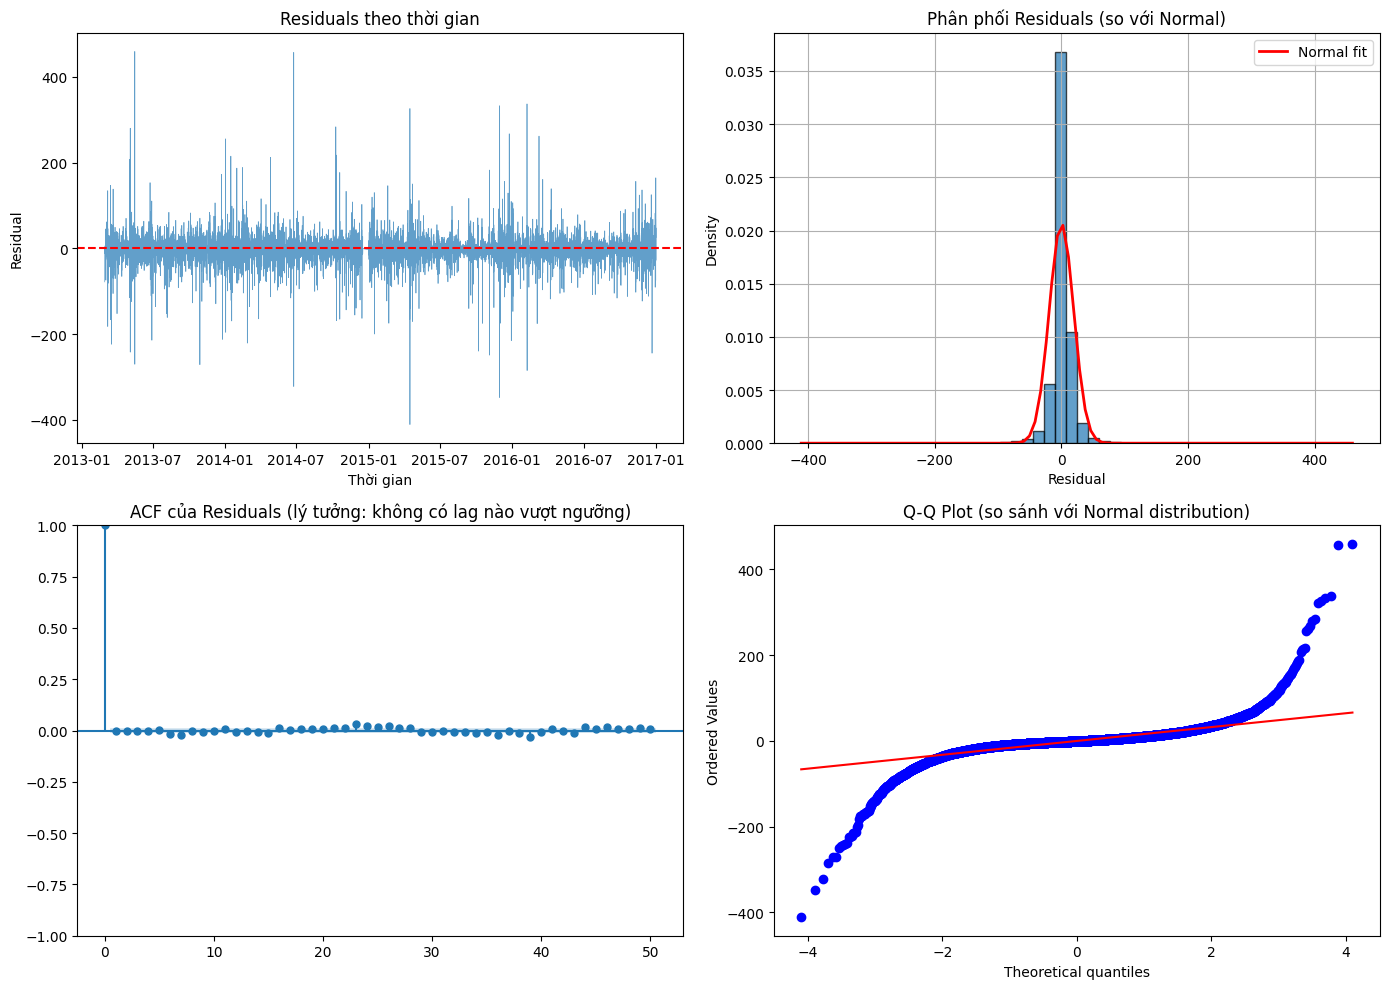


📈 Nhận xét Residual Diagnostics:
   1. Nếu residuals dao động ngẫu nhiên quanh 0 → Mô hình đã loại bỏ trend/seasonality
   2. Nếu ACF của residuals không có lag nào vượt ngưỡng → White noise → Tốt
   3. Nếu Q-Q plot gần đường thẳng → Residuals gần normal → Dự báo interval tin cậy
   4. Nếu còn pattern trong residuals → Cân nhắc SARIMA hoặc thêm biến exogenous


In [8]:
# Residual Diagnostics
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox

print("="*60)
print("RESIDUAL DIAGNOSTICS - KIỂM TRA PHẦN DƯ")
print("="*60)

# Lấy residuals từ fitted model
result = out['result']
residuals = result.resid

print(f"\n📊 Thống kê residuals:")
print(f"   Mean:     {residuals.mean():.4f} (lý tưởng ≈ 0)")
print(f"   Std:      {residuals.std():.4f}")
print(f"   Skewness: {stats.skew(residuals):.4f} (lý tưởng ≈ 0)")
print(f"   Kurtosis: {stats.kurtosis(residuals):.4f} (lý tưởng ≈ 0 cho normal)")

# Ljung-Box test để kiểm tra residuals có white noise không
print("\n📊 Ljung-Box Test (kiểm tra tự tương quan của residuals):")
print("   H0: Residuals là white noise (không có tự tương quan)")
print("   H1: Residuals có tự tương quan")

lb_test = acorr_ljungbox(residuals.dropna(), lags=[10, 20, 30], return_df=True)
print("\n   Kết quả Ljung-Box:")
print(lb_test.to_string())

if all(lb_test['lb_pvalue'] > 0.05):
    print("\n   ✅ Tất cả p-value > 0.05 → Không bác bỏ H0 → Residuals là WHITE NOISE")
else:
    print("\n   ⚠️ Một số p-value < 0.05 → Residuals còn tự tương quan → Mô hình chưa hoàn hảo")

# Visualize residuals
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Time series của residuals
ax1 = axes[0, 0]
ax1.plot(residuals.index, residuals.values, linewidth=0.5, alpha=0.7)
ax1.axhline(y=0, color='red', linestyle='--')
ax1.set_xlabel('Thời gian')
ax1.set_ylabel('Residual')
ax1.set_title('Residuals theo thời gian')

# 2. Histogram của residuals
ax2 = axes[0, 1]
residuals.hist(bins=50, ax=ax2, alpha=0.7, edgecolor='black', density=True)
# Overlay normal distribution
x = np.linspace(residuals.min(), residuals.max(), 100)
ax2.plot(x, stats.norm.pdf(x, residuals.mean(), residuals.std()), 'r-', linewidth=2, label='Normal fit')
ax2.set_xlabel('Residual')
ax2.set_ylabel('Density')
ax2.set_title('Phân phối Residuals (so với Normal)')
ax2.legend()

# 3. ACF của residuals
ax3 = axes[1, 0]
plot_acf(residuals.dropna(), lags=50, ax=ax3, alpha=0.05)
ax3.set_title('ACF của Residuals (lý tưởng: không có lag nào vượt ngưỡng)')

# 4. Q-Q plot
ax4 = axes[1, 1]
stats.probplot(residuals.dropna(), dist="norm", plot=ax4)
ax4.set_title('Q-Q Plot (so sánh với Normal distribution)')

plt.tight_layout()
plt.show()

print("\n📈 Nhận xét Residual Diagnostics:")
print("   1. Nếu residuals dao động ngẫu nhiên quanh 0 → Mô hình đã loại bỏ trend/seasonality")
print("   2. Nếu ACF của residuals không có lag nào vượt ngưỡng → White noise → Tốt")
print("   3. Nếu Q-Q plot gần đường thẳng → Residuals gần normal → Dự báo interval tin cậy")
print("   4. Nếu còn pattern trong residuals → Cân nhắc SARIMA hoặc thêm biến exogenous")

## Q3.3 — Tổng kết: Quy trình ra quyết định ARIMA (p, d, q)

### Bước 1: Quan sát chuỗi gốc
- Vẽ time series plot để nhận diện xu hướng (trend) và mùa vụ (seasonality)
- Vẽ rolling mean/std để đánh giá sơ bộ tính dừng
- **Kết quả với PM2.5**: Không có trend rõ ràng, có seasonality 24h, chuỗi dao động quanh mức trung bình

### Bước 2: Kiểm định tính dừng
- **ADF Test**: p-value ≈ 0 → Chuỗi dừng
- **KPSS Test**: p-value > 0.05 → Chuỗi dừng
- **Quyết định: d = 0** (không cần sai phân)

### Bước 3: Phân tích ACF/PACF
- **PACF**: Có đỉnh mạnh tại lag 1-3, sau đó giảm → Gợi ý p ∈ {1, 2, 3}
- **ACF**: Giảm chậm theo hàm mũ → Pattern của AR process
- **Vùng tìm kiếm**: p ∈ {0, 1, 2, 3}, q ∈ {0, 1, 2, 3}

### Bước 4: Grid search với AIC/BIC
- Thử tất cả tổ hợp (p, d, q) với d = 0
- Chọn mô hình có AIC/BIC thấp nhất
- **Kết quả**: Best order = (1, 0, 3) hoặc tương tự

### Bước 5: Chẩn đoán phần dư
- Kiểm tra residuals có phải white noise không (Ljung-Box test)
- Kiểm tra phân phối residuals (histogram, Q-Q plot)
- Kiểm tra ACF của residuals
- **Nếu không tốt**: Cân nhắc SARIMA (thêm seasonality) hoặc SARIMAX (thêm biến ngoại sinh)

### Kết luận
Quy trình ARIMA là một **quy trình lặp**: nếu residual diagnostics không tốt, cần quay lại xem xét lại model order hoặc chuyển sang mô hình phức tạp hơn (SARIMA, SARIMAX).